In [1]:
import math
import copy
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
import pandas as pd
import time

import pickle

In [2]:
class CIFAR10Corrupted(CIFAR10):
    def __init__(self, corrupt_prob, num_classes=10, **kwargs):
        super().__init__(**kwargs)
        if corrupt_prob > 0:
            self.n_classes = num_classes
            self.corrupt_labels(corrupt_prob)

    def corrupt_labels(self, corrupt_prob):
        labels = np.array(self.targets)
        np.random.seed(42)
        mask = np.random.rand(len(labels)) <= corrupt_prob
        rnd_labels = np.random.choice(self.n_classes, mask.sum())
        labels[mask] = rnd_labels
        labels = [int(x) for x in labels]
        self.targets = labels

In [3]:
def get_cifar_dataloaders_corrupted(corrupt_prob=0, batch_size=32):
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = CIFAR10Corrupted(root='./CIFAR', train=True, download=True, transform=transform, corrupt_prob=corrupt_prob)
    train_loader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
    testset = CIFAR10Corrupted(root='./CIFAR', train=False, download=True, transform=transform, corrupt_prob=corrupt_prob)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader



In [4]:
'''InceptionNet with PyTorch.'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)


class InceptionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)

    def forward(self, x):
        out = self.pre_layers(x)
        out = self.a3(out)
        out = self.b3(out)
        out = self.maxpool(out)
        out = self.a4(out)
        out = self.b4(out)
        out = self.c4(out)
        out = self.d4(out)
        out = self.e4(out)
        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out




In [5]:
def run_train_single_epoch(train_loader, model, device, criterion, optimizer):
    running_loss = 0.0
    num_correct = 0
    for batch_num, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*len(inputs)
        if batch_num%200==0:
            print("Batch {} Loss: {}".format(batch_num, loss.item()))
        preds = outputs.argmax(1)
        num_correct += (preds==labels).sum().item()
    epoch_loss = running_loss/len(train_loader.sampler)
    epoch_acc = num_correct/len(train_loader.sampler)
    return epoch_loss, epoch_acc

def run_validation_single_epoch(valid_loader, model, device, criterion):
    running_loss = 0.0
    num_correct = 0
    for batch_num, data in enumerate(valid_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()*len(inputs)
        preds = outputs.argmax(1)
        num_correct += (preds==labels).sum().item()
    epoch_loss = running_loss/len(valid_loader.sampler)
    epoch_acc = num_correct/len(valid_loader.sampler)
    return epoch_loss, epoch_acc

def training_loop(model, num_epochs, train_loader, valid_loader, device, \
                  criterion, optimizer, model_name):
    train_losses, valid_losses = [], []
    train_accs, valid_accs = [], []
    highest_acc = 1e-10
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_acc = run_train_single_epoch(train_loader, model, device, criterion, optimizer)
        model.eval()
        valid_loss, valid_acc = run_validation_single_epoch(valid_loader, model, device, criterion)
        print("[Epoch {}] Train Loss: {} Vaidation Loss: {} Train Acc: {} Validation Acc: {}".format(\
              epoch, train_loss, valid_loss, train_acc, valid_acc))
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)
        if valid_acc > highest_acc:
            torch.save(model.state_dict(), "{}.pth".format(model_name))
            highest_acc = valid_acc
        else:
            print("Early stopping.")
            break
    print('Finished Training')
    return train_losses, valid_losses, train_accs, valid_accs

def run_testing(test_loader, model, device):
    model.eval()
    gt_all, preds_all = [], []
    for batch_num, data in enumerate(test_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(1)
        gt_all.extend(labels.tolist())
        preds_all.extend(preds.tolist())
    return gt_all, preds_all
    

In [6]:
def plot_losses(training_loss_arr, validation_loss_arr, training_acc_arr, validation_acc_arr, \
                title):
    num_epochs = len(training_loss_arr)
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    ax = plt.gca()
    ax.plot(range(num_epochs), training_loss_arr, '-bo', label="Training Loss")
    ax.plot(range(num_epochs), validation_loss_arr, '-ro', label="Validation Loss")
    ax.legend()
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title(title)
    plt.subplot(1,2,2)
    ax = plt.gca()
    ax.plot(range(num_epochs), training_acc_arr, '-bo', label="Training Acc")
    ax.plot(range(num_epochs), validation_acc_arr, '-ro', label="Validation Acc")
    ax.legend()
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.set_title(title)    

In [7]:
final_dict = dict()

In [8]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(0)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


Files already downloaded and verified
Files already downloaded and verified
cuda:0


In [9]:
model = InceptionNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [10]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 10, train_loader, test_loader,
                                          device, criterion, optimizer, "InceptionNet_corr_0")

Batch 0 Loss: 2.3301613330841064
Batch 200 Loss: 1.6887069940567017
Batch 400 Loss: 1.4951298236846924
Batch 600 Loss: 1.2481932640075684
Batch 800 Loss: 0.9630700945854187
Batch 1000 Loss: 0.7693376541137695
Batch 1200 Loss: 1.3612772226333618
Batch 1400 Loss: 0.895154595375061
[Epoch 0] Train Loss: 1.283070360660553 Vaidation Loss: 0.9989812486648559 Train Acc: 0.53642 Validation Acc: 0.6468
Batch 0 Loss: 1.081649899482727
Batch 200 Loss: 1.2003997564315796
Batch 400 Loss: 0.7467864751815796
Batch 600 Loss: 1.078070044517517
Batch 800 Loss: 0.4932956397533417
Batch 1000 Loss: 0.8093253374099731
Batch 1200 Loss: 0.7441786527633667
Batch 1400 Loss: 0.35177814960479736
[Epoch 1] Train Loss: 0.8009998249530792 Vaidation Loss: 0.6850460106849671 Train Acc: 0.72068 Validation Acc: 0.7621
Batch 0 Loss: 0.5411682724952698
Batch 200 Loss: 0.4767336845397949
Batch 400 Loss: 0.7084962725639343
Batch 600 Loss: 0.5677611231803894
Batch 800 Loss: 0.4581506848335266
Batch 1000 Loss: 0.4654631614685

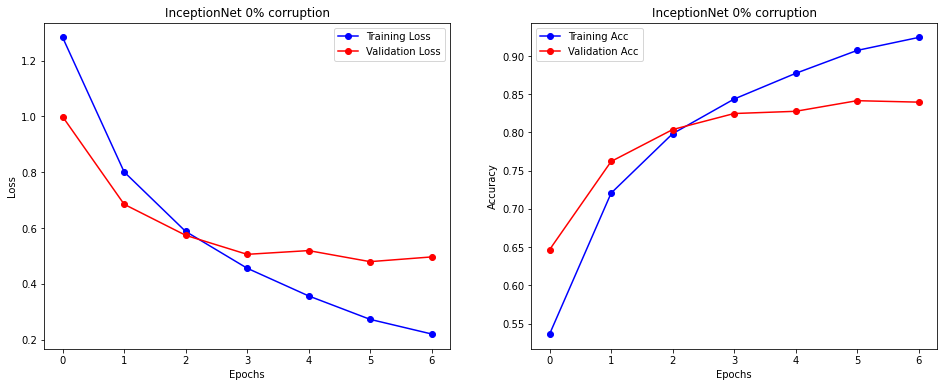

In [11]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "InceptionNet 0% corruption")

In [12]:
model = InceptionNet()
sd = torch.load("InceptionNet_corr_0.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


Accuracy: 0.8416
Confusion Matrix:
 [[756  13  37  21  42  10  20  17  59  25]
 [  3 926   2   0   2   6   7   4   5  45]
 [ 30   1 740  33  69  45  58  18   6   0]
 [  3   3  32 738  40 110  32  30   2  10]
 [  3   0  27  27 867  19  31  23   2   1]
 [  1   1  12 117  32 801   6  27   1   2]
 [  3   0  14  37  22  22 897   4   0   1]
 [  3   0  14  25  42  34   3 872   0   7]
 [ 20  21   6  13   3   5   7   4 900  21]
 [  3  45   5   4   1   2   3   8  10 919]]


In [13]:
final_dict[0] = {}
final_dict[0]["train_losses"] = train_losses
final_dict[0]["valid_losses"] = valid_losses
final_dict[0]["train_accs"] = train_accs
final_dict[0]["validation_accs"] = validation_accs
final_dict[0]["best_test_acc"] = accuracy_score(testy, pred)


In [14]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(0.2)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


Files already downloaded and verified
Files already downloaded and verified
cuda:0


In [15]:
model = InceptionNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [16]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 10, train_loader, test_loader,
                                          device, criterion, optimizer, "InceptionNet_corr_20")

Batch 0 Loss: 2.3577497005462646
Batch 200 Loss: 1.5639773607254028
Batch 400 Loss: 1.860716462135315
Batch 600 Loss: 1.7387032508850098
Batch 800 Loss: 2.111366033554077
Batch 1000 Loss: 2.242556571960449
Batch 1200 Loss: 1.6796114444732666
Batch 1400 Loss: 2.0110745429992676
[Epoch 0] Train Loss: 1.769201702041626 Vaidation Loss: 1.7166523706436156 Train Acc: 0.40736 Validation Acc: 0.4527
Batch 0 Loss: 1.670096516609192
Batch 200 Loss: 1.89340341091156
Batch 400 Loss: 1.50209379196167
Batch 600 Loss: 1.541571021080017
Batch 800 Loss: 1.6448633670806885


KeyboardInterrupt: ignored

In [ ]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "InceptionNet 20% corruption")

In [ ]:
model = InceptionNet()
sd = torch.load("InceptionNet_corr_20.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


In [ ]:
final_dict[20] = {}
final_dict[20]["train_losses"] = train_losses
final_dict[20]["valid_losses"] = valid_losses
final_dict[20]["train_accs"] = train_accs
final_dict[20]["validation_accs"] = validation_accs
final_dict[20]["best_test_acc"]  = accuracy_score(testy, pred)


In [ ]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(0.4)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


In [ ]:
model = InceptionNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [ ]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 10, train_loader, test_loader,
                                          device, criterion, optimizer, "InceptionNet_corr_40")

In [ ]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "InceptionNet 40% corruption")

In [ ]:
model = InceptionNet()
sd = torch.load("InceptionNet_corr_40.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


In [ ]:
final_dict[40] = {}
final_dict[40]["train_losses"] = train_losses
final_dict[40]["valid_losses"] = valid_losses
final_dict[40]["train_accs"] = train_accs
final_dict[40]["validation_accs"] = validation_accs
final_dict[40]["best_test_acc"]  = accuracy_score(testy, pred)


In [ ]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(0.6)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


In [ ]:
model = InceptionNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [ ]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 10, train_loader, test_loader,
                                          device, criterion, optimizer, "InceptionNet_corr_60")

In [ ]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "InceptionNet 60% corruption")

In [ ]:
model = InceptionNet()
sd = torch.load("InceptionNet_corr_60.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


In [ ]:
final_dict[60] = {}
final_dict[60]["train_losses"] = train_losses
final_dict[60]["valid_losses"] = valid_losses
final_dict[60]["train_accs"] = train_accs
final_dict[60]["validation_accs"] = validation_accs
final_dict[60]["best_test_acc"]  = accuracy_score(testy, pred)


In [ ]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(0.8)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


In [ ]:
model = InceptionNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [ ]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 10, train_loader, test_loader,
                                          device, criterion, optimizer, "InceptionNet_corr_80")

In [ ]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "InceptionNet 80% corruption")

In [ ]:
model = InceptionNet()
sd = torch.load("InceptionNet_corr_80.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


In [ ]:
final_dict[80] = {}
final_dict[80]["train_losses"] = train_losses
final_dict[80]["valid_losses"] = valid_losses
final_dict[80]["train_accs"] = train_accs
final_dict[80]["validation_accs"] = validation_accs
final_dict[80]["best_test_acc"]  = accuracy_score(testy, pred)


In [ ]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(1.0)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


In [ ]:
model = InceptionNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [ ]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 10, train_loader, test_loader,
                                          device, criterion, optimizer, "InceptionNet_corr_100")

In [ ]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "InceptionNet 100% corruption")

In [ ]:
model = InceptionNet()
sd = torch.load("InceptionNet_corr_100.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


In [ ]:
final_dict[100] = {}
final_dict[100]["train_losses"] = train_losses
final_dict[100]["valid_losses"] = valid_losses
final_dict[100]["train_accs"] = train_accs
final_dict[100]["validation_accs"] = validation_accs
final_dict[100]["best_test_acc"]  = accuracy_score(testy, pred)


In [ ]:
with open('final.pickle', 'wb') as f:
    pickle.dump(final_dict, f, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
!curl bashupload.com -T final.pickle

In [ ]:
!zip inception.zip *.*
!curl bashupload.com -T inception.zip